# Notebook de ejemplo – Toolbox ML

Este notebook muestra un ejemplo de uso del módulo `toolbox_ML.py`
para análisis exploratorio y selección de variables, aplicado al dataset "dataset_viajes_jun23".

### Índice
1. [Carga de librerías y módulo](#1-carga-de-librerías-y-módulo)
2. [Carga de datos](#2-carga-de-datos)
3. [Análisis estructural](#3-análisis-estructural)
4. [Tipificación de variables](#4-tipificación-de-variables)
5. [Análisis de variables numéricas: regresión](#5-análisis-de-variables-numéricas-regresión)
6. [Análisis de variables categóricas: regresión](#6-análisis-de-variables-categóricas-regresión)

## 1. Carga de librerías y módulo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import toolbox_ML as tb


## 2. Carga de datos

Realizamos la carga del dataset y hacemos una inspección inicial

In [3]:
df = pd.read_csv("./data/dataset_viajes_jun23.csv")
df.head()

,aircompany,origen,destino,distancia,avion,con_escala,consumo_kg,duracion,ingresos,id_vuelo,mes
0,Airnar,París,Ginebra,411,Boeing 737,False,1028.691900,51,14232.65,Air_PaGi_10737,Jun23
1,FlyQ,Bali,Roma,12738,Boeing 737,True,33479.132544,1167,468527.19,Fly_BaRo_10737,Jun23
2,TabarAir,Ginebra,Los Angeles,9103,Airbus A380,False,109439.907200,626,584789.19,Tab_GiLo_11380,Jun23
3,MoldaviAir,París,Cincinnati,6370,Boeing 737,False,17027.010000,503,233342.51,Mol_PaCi_10737,Jun23
4,TabarAir,Cincinnati,Roma,7480,Boeing 747,False,86115.744000,518,438535.07,Tab_CiRo_10747,Jun23


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   aircompany  600 non-null    str    
 1   origen      600 non-null    str    
 2   destino     600 non-null    str    
 3   distancia   600 non-null    int64  
 4   avion       600 non-null    str    
 5   con_escala  600 non-null    bool   
 6   consumo_kg  600 non-null    float64
 7   duracion    600 non-null    int64  
 8   ingresos    600 non-null    float64
 9   id_vuelo    600 non-null    str    
 10  mes         600 non-null    str    
dtypes: bool(1), float64(2), int64(2), str(6)
memory usage: 47.6 KB


## 3. Análisis estructural

La función `describe_df` realiza un resumen estructural del DataFrame, devolviendo para cada columna:
- Tipo de dato 
- Porcentaje de valores nulos
- Número de valores únicos
- Cardinalidad relativa

In [5]:
tb.describe_df(df)

COL_N,aircompany,origen,destino,distancia,avion,con_escala,consumo_kg,duracion,ingresos,id_vuelo,mes
DATA_TYPE,str,str,str,int64,str,bool,float64,int64,float64,str,str
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,5,11,11,45,4,2,501,113,600,347,1
CARDIN (%),0.83,1.83,1.83,7.5,0.67,0.33,83.5,18.83,100.0,57.83,0.17


## 4. Tipificación de variables
La función `tipifica_variables` realiza una clasificación inicial de las variables según su cardinalidad, para orientar el análisis exploratorio (no para sustituir el criterio del analista).
- Binaria: si tiene dos valores distintos
- Categórica: si tiene pocos valores distintos, menos que el `umbral_categoria`
- Numérica discreta: si tiene muchos valores distintos, pero el porcentaje de cardinalidad es bajo
- Numérica continua: si tiene muchos valores distintos y el porcentaje de cardinalidad supera `umbral_continua`

In [7]:
tb.tipifica_variables(df, umbral_categoria=12, umbral_continua=7.5)

,nombre_variable,tipo_sugerido
0,aircompany,Categórica
1,origen,Categórica
2,destino,Categórica
3,distancia,Numérica Continua
4,avion,Categórica
5,con_escala,Binaria
6,consumo_kg,Numérica Continua
7,duracion,Numérica Continua
8,ingresos,Numérica Continua
9,id_vuelo,Numérica Continua


## 5. Análisis de variables numéricas: regresión
### 5.1. Función get_features_num_regression
La función `get_features_num_regression` identifica variables numéricas potencialmente relevantes para un problema de regresión, evaluando su relación estadísticamente significativa con la variable target mediante correlación lineal. Aporta una lista de variables numéricas relevantes.

In [8]:
features_num = tb.get_features_num_regression(df, target_col="ingresos", umbral_corr=0.3, pvalue=0.05)
features_num

['distancia', 'consumo_kg', 'duracion']

### 5.2. Función plot_features_num_regression
La función `plot_features_num_regression` genera gráficos de dispersión entre el target y las variables numéricas que superan el test de significancia. Lo que permite visualizar relaciones lineales o no lineales, y detectar outliers.  

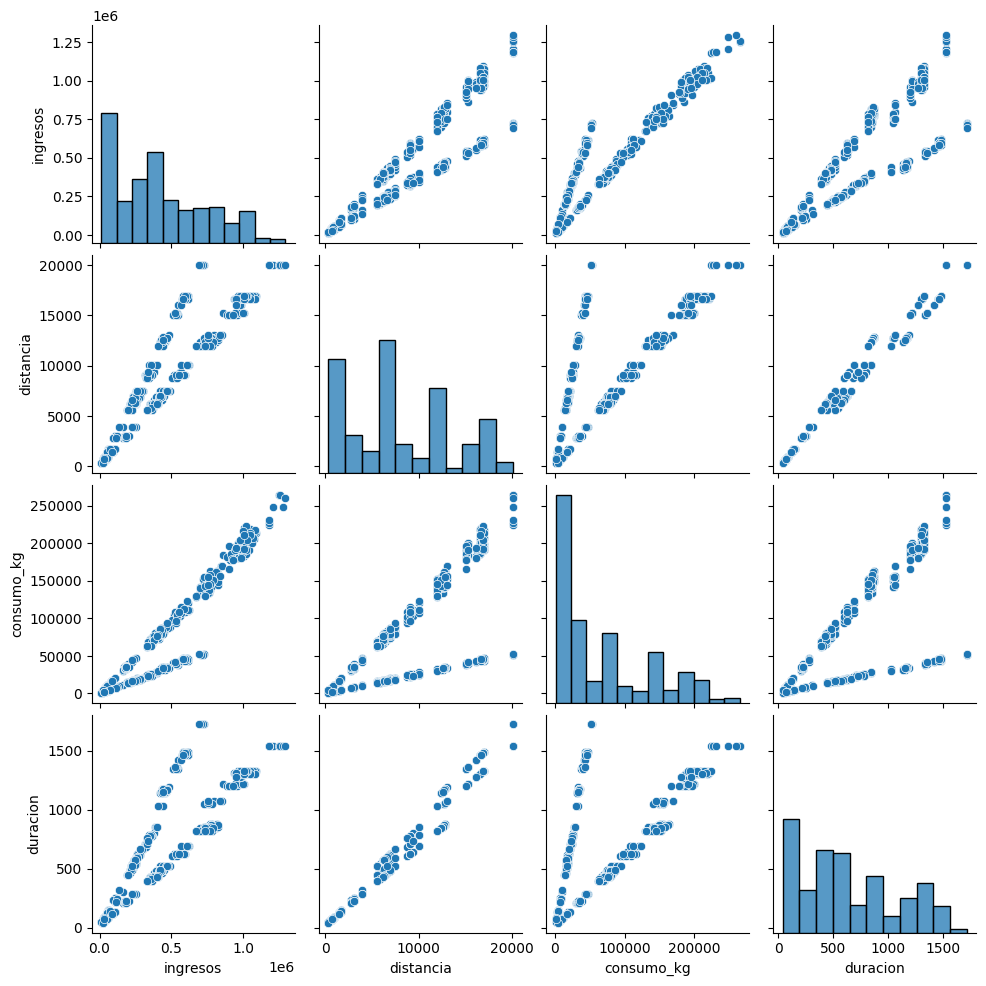

['distancia', 'consumo_kg', 'duracion']

In [9]:
tb.plot_features_num_regression(df, target_col="ingresos",columns= features_num, umbral_corr=0.3, pvalue= 0.05)



## 6. Análisis de variables categóricas: regresión
### 6.1.  Función get_features_cat_regression
La función `get_features_cat_regression` identifica variables categóricas que tienen relación significativa con la variable tárget numérica. Dependiendo del número de categorías, elegirá un test u otro, aportando una lista de variables categóricas relevantes: 
- 2 categorías → T-Test de Welch: comprueba si la media del grupo 0 es muy distinta de la media del grupo 1. Si la diferencia es muy grande, hay relación estadística. Este test no asume varianzas iguales ni tamaños de muestras iguales, ya que hay categorías que tiene más registros que otras.
- +2 categorías → Test de Anova: Comprueba si las medias de los grupos son iguales o al menos una es distinta. Si hay distintas, hay relación estadística y es entonces una variable interesante para analizar.

In [12]:
cols_sel_cat= tb.get_features_cat_regression(df, "ingresos", pvalue=0.05)
cols_sel_cat

['aircompany', 'origen', 'destino', 'avion', 'con_escala']

### 6.2. Función plot_features_cat_regression
La función `plot_features_cat_regression` genera histogramas del target numérico agrupados por cada variables categórica significativa. Permite comparar distribuciones e identificar diferencias claras entre grupos.

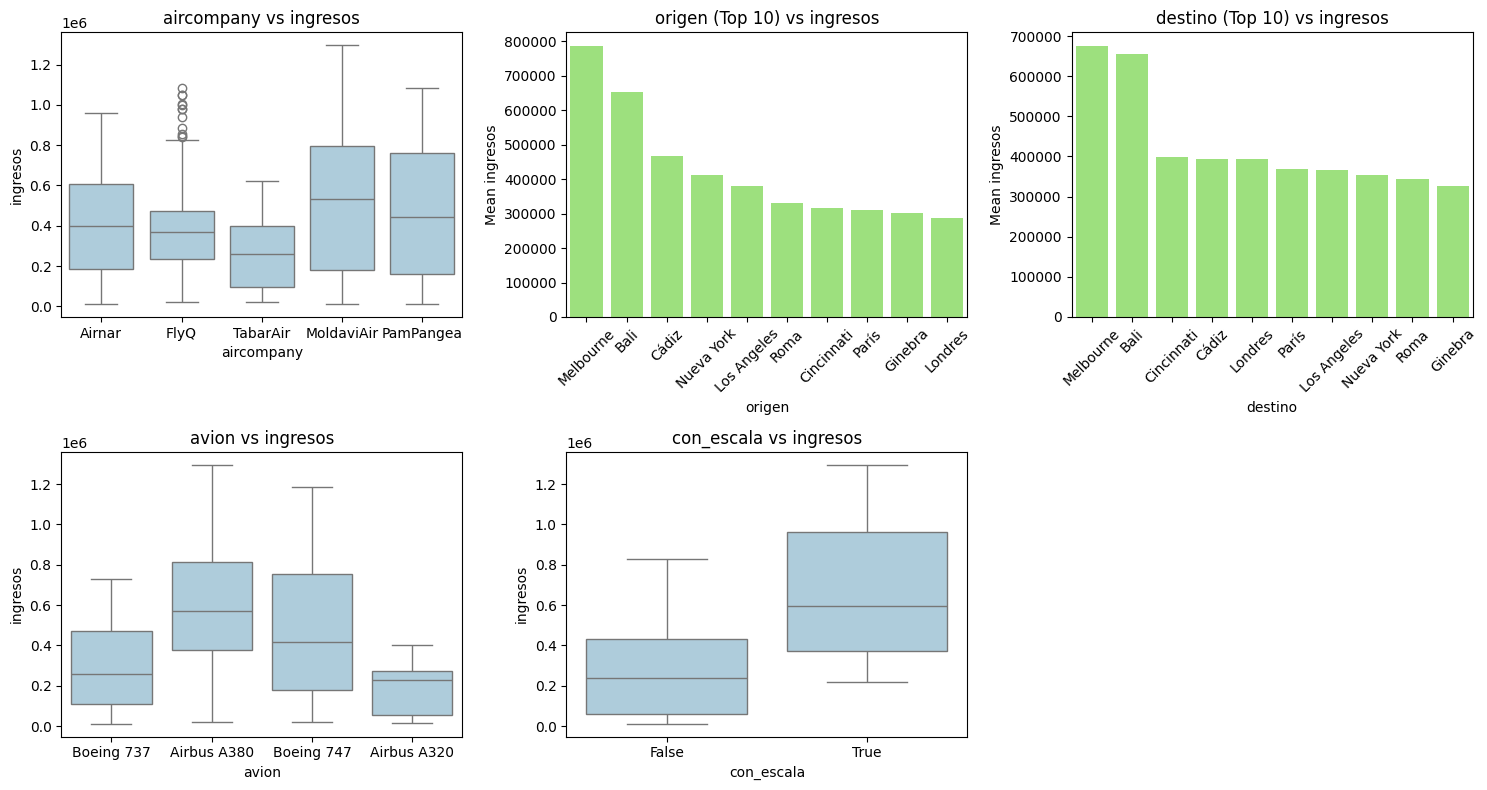

In [13]:
from toolbox_ML import plot_features_cat_regression
plot_features_cat_regression(df, "ingresos", pvalue= 0.05, with_individual_plot=True);